In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from typing import Tuple
from tqdm.auto import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam


warnings.filterwarnings("ignore")
plt.ion()
np.set_printoptions(suppress=True)

In [2]:
IMAGES_ROOT = "../data/raw/screenshot"

In [3]:
image_data = pd.DataFrame(columns=["id", "filepath", "longitude", "latitude"])

for filename in os.listdir(IMAGES_ROOT):
    id_value, latitude, longitude = os.path.splitext(filename)[0].split(" ")
    row = {"id": int(id_value),
           "filepath": os.path.join(IMAGES_ROOT, filename),
           "longitude": float(longitude),
           "latitude": float(latitude)}

    image_data = pd.concat([image_data, pd.DataFrame([row])], ignore_index=True)

image_data.describe()

longitude     latitude
count  2702.000000  2702.000000
mean     97.259122   -74.638646
std      34.390110    23.063772
min      25.027340  -124.453120
25%      70.625000   -90.711422
50%      95.059570   -73.125000
75%     118.750000   -56.261720
max     171.998050   -25.625000

In [4]:
mean = [0.3811, 0.4027, 0.3743]
std = [0.2466, 0.2669, 0.2955]

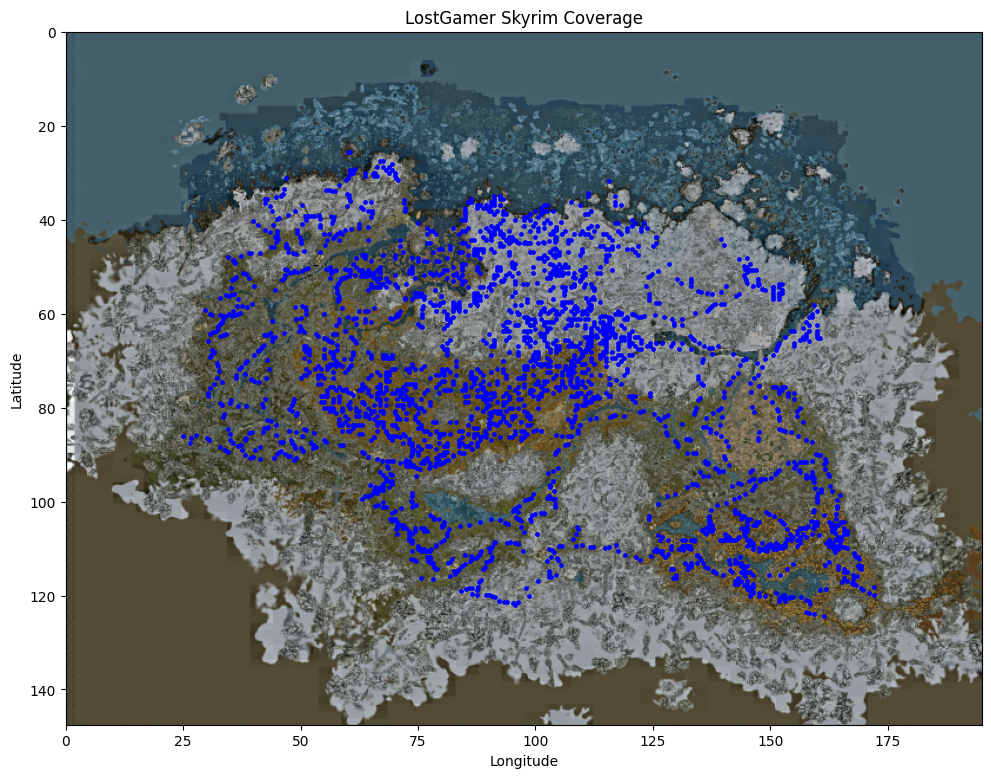

In [5]:
BACKGROUND_PLOT_IMAGE = plt.imread("../assets/skyrim_map_lostgamer.png")
LONGITUDE_MIN, LONGITUDE_MAX  = 0, 195
LATITUDE_MIN, LATITUDE_MAX = 0, 147.5

fig_coverage, ax_coverage = plt.subplots(figsize=(12, 9))

ax_coverage.imshow(BACKGROUND_PLOT_IMAGE, extent=[LONGITUDE_MIN, LONGITUDE_MAX, LATITUDE_MAX, LATITUDE_MIN])

plt.scatter(image_data.longitude, -1 * image_data.latitude, c="blue", label="True", s=6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("LostGamer Skyrim Coverage")

plt.show()

In [6]:
TOTAL_SAMPLES = len(image_data)
TRAIN_LEN = int(0.75 * TOTAL_SAMPLES)
VAL_LEN = int(0.1 * TRAIN_LEN)
TEST_LEN = TOTAL_SAMPLES - TRAIN_LEN - VAL_LEN

print(f"Total Samples: {TOTAL_SAMPLES}\nTrain Samples: {TRAIN_LEN}\nValidation Samples: {VAL_LEN}\nTest Samples: {TEST_LEN}")

shuffled_data = image_data.sample(frac=1, random_state=42).reset_index(drop=True)

train_data = shuffled_data[:TRAIN_LEN]
val_data = shuffled_data[TRAIN_LEN:TRAIN_LEN+VAL_LEN]
test_data = shuffled_data[TRAIN_LEN+VAL_LEN:]

Total Samples: 2702
Train Samples: 2026
Validation Samples: 202
Test Samples: 474


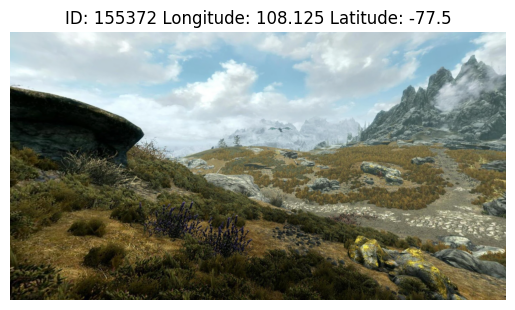

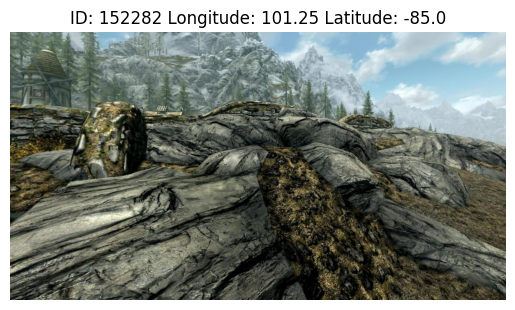

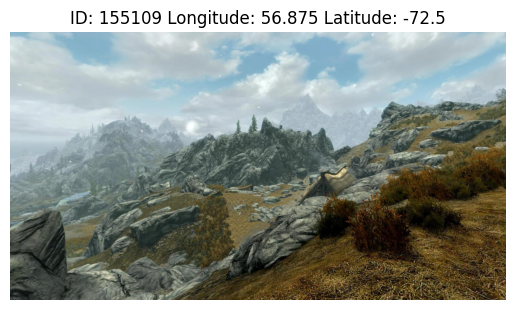

In [7]:
def show_random_samples(dataframe: pd.DataFrame, n: int) -> None:
    random_samples = dataframe.sample(n)

    for _, row in random_samples.iterrows():
        id, image_path, longitude, latitude = row
        image = Image.open(image_path)

        plt.figure()
        plt.imshow(image)
        plt.title(f"ID: {id} Longitude: {longitude} Latitude: {latitude}")
        plt.axis("off")
        plt.show()
        
show_random_samples(image_data, 3)

In [8]:
train_transform = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.RandomChoice([
        transforms.Pad(padding=10),
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.RandomResizedCrop(size=(540, 1000)),
        transforms.RandomAffine(degrees=(-10, 10), scale=(0.9, 1.1), shear=(-10, 10)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ]),
    transforms.CenterCrop((462, 855)),
    transforms.Resize((462, 855)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((462, 855)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


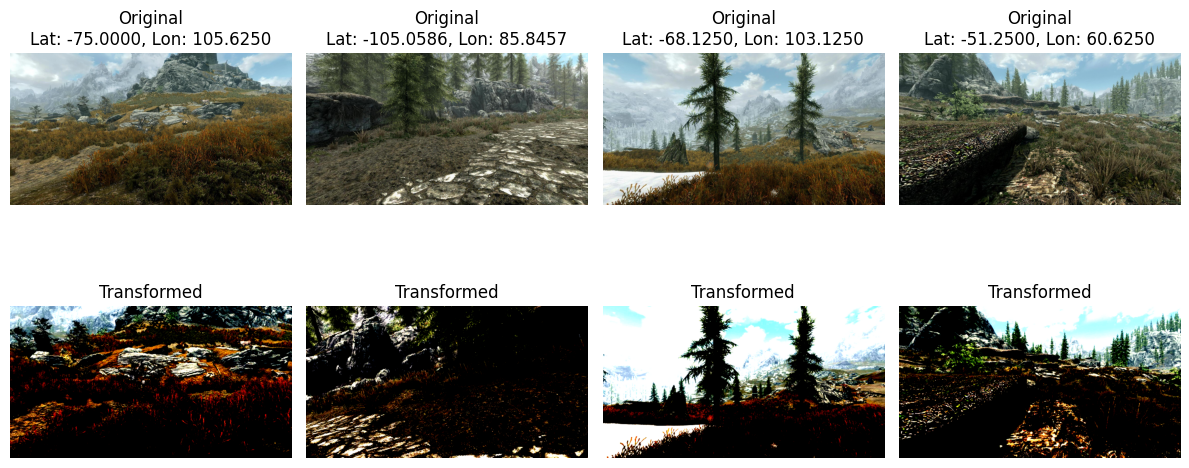

In [9]:
def apply_transforms_and_plot(dataframe, train_transform, test_transform, n=4):
    random_samples = dataframe.sample(n)
    fig, axes = plt.subplots(2, n, figsize=(12, 6))
    i = 0
    for _, row in random_samples.iterrows():
        id, image_path, longitude, latitude = row
        image = Image.open(image_path)
        if i < n // 2:
            transformed_image = train_transform(image)
        else:
            transformed_image = test_transform(image)

        axes[0][i].imshow(image)
        axes[0][i].set_title(f"Original\nLat: {latitude:.4f}, Lon: {longitude:.4f}")
        axes[0][i].axis('off')

        axes[1][i].imshow(transformed_image.permute(1, 2, 0))
        axes[1][i].set_title("Transformed")
        axes[1][i].axis('off')
        i += 1

    plt.tight_layout()
    plt.show()

apply_transforms_and_plot(image_data, train_transform, test_transform, n=4)

In [10]:
class SkyrimLocationsDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, is_train: bool, transform=None):
        self.input = dataframe
        self.is_train = is_train
        self.transform = transform

    def __len__(self) -> int:
        return len(self.input)

    def __getitem__(self, idx: int | torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.is_train:
            id, filepath, longitude, latitude = self.input.iloc[idx]
            target_tensor = torch.Tensor([longitude, latitude])
        else:
            id, filepath = self.input.iloc[idx]
            target_tensor =  torch.Tensor([1, 1])

        image = Image.open(filepath)
        sample = self.transform(image)
        return sample, target_tensor

In [11]:
BATCH_SIZE = 4
LEARNING_RATE = 10 ** -4
NUM_EPOCHS = 70

In [12]:
train_dataset = SkyrimLocationsDataset(train_data, transform=train_transform, is_train=True)
val_dataset = SkyrimLocationsDataset(val_data, transform=test_transform, is_train=True)
test_dataset = SkyrimLocationsDataset(test_data, transform=test_transform, is_train=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [13]:
# 64 * 84 * 42 - 675x338
# 64 * 32 * 32 - 256x256
# 64 * 28 * 28 - 224x224
# 64 * 106 * 57 - 855x462 (60% 1425x770)
# 128 * 71 * 38 - 570x308 (40% 1425x770)
# 128 * 106 * 57 - 855x462 (60% 1425x770)
# 128 * 142 * 77 - 1140x616 (80% 1425x770) 128, 72, 133
# 128 * 178 * 96 - 1425x770 (100%)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.dropout = nn.Dropout(0.2)

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 106 * 57, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc_layers(x)
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
device

device(type='cuda')

In [15]:
cnn = CNNModel()
cnn.to(device)
cnn.train()

criterion = nn.MSELoss()
optimizer = Adam(cnn.parameters(), lr=LEARNING_RATE)

In [19]:
train_losses = np.array([])
val_losses = np.array([])
SAVE_MODEL_PATH = "../models/torch-cnn-60%-v2"

for epoch in tqdm(range(NUM_EPOCHS)):
    cnn.train()
    running_loss = 0
    for inputs, coordinates in train_loader:
        inputs = inputs.to(device)
        coordinates = coordinates.to(device)
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, coordinates)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses = np.append(train_losses, train_loss)

    cnn.eval()
    running_loss = 0
    with torch.no_grad():
        for inputs, coordinates in val_loader:
            inputs = inputs.to(device)
            coordinates = coordinates.to(device)
            outputs = cnn(inputs)
            loss = criterion(outputs, coordinates)
            running_loss += loss.item()

    val_loss = running_loss / len(val_loader)
    if val_losses.size == 0 or np.min(val_losses) >= val_loss:
        torch.save(cnn.state_dict(), SAVE_MODEL_PATH)

    val_losses = np.append(val_losses, val_loss)

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/70: Train Loss: 948.3184, Val Loss: 685.8344
Epoch 2/70: Train Loss: 759.0116, Val Loss: 693.2060
Epoch 3/70: Train Loss: 739.0494, Val Loss: 597.5488
Epoch 4/70: Train Loss: 714.9151, Val Loss: 716.4433
Epoch 5/70: Train Loss: 713.1471, Val Loss: 567.3182
Epoch 6/70: Train Loss: 687.8779, Val Loss: 696.0059
Epoch 7/70: Train Loss: 666.9484, Val Loss: 565.8333
Epoch 8/70: Train Loss: 641.9271, Val Loss: 528.8006
Epoch 9/70: Train Loss: 626.8655, Val Loss: 589.0434
Epoch 10/70: Train Loss: 629.4479, Val Loss: 553.3377
Epoch 11/70: Train Loss: 606.6274, Val Loss: 523.6426
Epoch 12/70: Train Loss: 591.4574, Val Loss: 527.9364
Epoch 13/70: Train Loss: 596.0176, Val Loss: 511.4453
Epoch 14/70: Train Loss: 581.5215, Val Loss: 493.2769
Epoch 15/70: Train Loss: 592.4270, Val Loss: 508.9658
Epoch 16/70: Train Loss: 579.8605, Val Loss: 535.4902
Epoch 17/70: Train Loss: 580.0450, Val Loss: 518.4544
Epoch 18/70: Train Loss: 582.0748, Val Loss: 486.6733
Epoch 19/70: Train Loss: 552.7976, Va

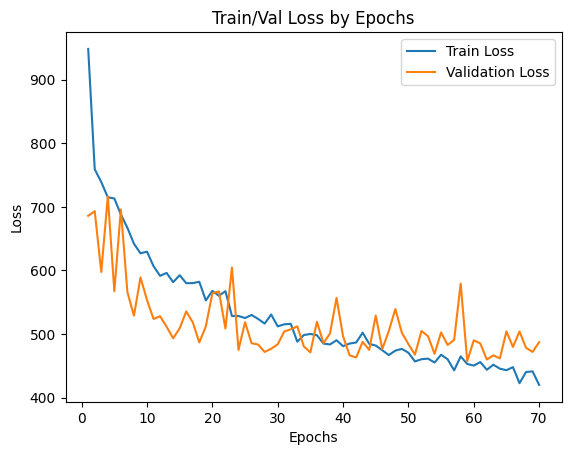

In [20]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Val Loss by Epochs")
plt.legend()
plt.show()

In [16]:
LOAD_MODEL_PATH = "../models/torch-cnn-60%-v6-408.pt"

cnn = CNNModel()
cnn.to(device)
cnn.load_state_dict(torch.load(LOAD_MODEL_PATH))

test_loss = 0
y_true = []
y_pred = []

cnn.eval()
with torch.no_grad():
    for inputs, coordinates in test_loader:
        inputs = inputs.to(device)
        coordinates = coordinates.to(device)

        outputs = cnn(inputs)
        loss = criterion(outputs, coordinates)
        test_loss += loss.item()

        y_true.append(coordinates.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 408.8101


In [17]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true = y_true.reshape(y_true.shape[0], 2)
y_pred = y_pred.reshape(y_pred.shape[0], 2)

In [19]:
data = {
    "true_longitude": y_true[:, 0],
    "pred_longitude": y_pred[:, 0],
    "true_latitude": y_true[:, 1],
    "pred_latitude": y_pred[:, 1]
}

predicted_coordinates = pd.DataFrame(data)
predicted_coordinates

true_longitude  pred_longitude  true_latitude  pred_latitude
0         43.052731       78.791046     -84.212891     -80.567284
1        133.669922      103.445297     -81.304688     -84.273949
2         68.322273       72.023155     -53.078121     -68.290871
3         82.500000       82.328232     -53.125000     -51.852005
4         86.250000       87.237732     -44.375000     -53.709385
..              ...             ...            ...            ...
469       76.875000       82.286972     -45.000000     -50.769196
470       81.250000       83.722702     -76.250000     -80.039024
471      110.625000      108.540863     -51.875000     -53.417149
472       53.750000       81.811600     -71.250000     -77.826103
473       98.359383       85.995323     -99.470703     -87.397820

[474 rows x 4 columns]

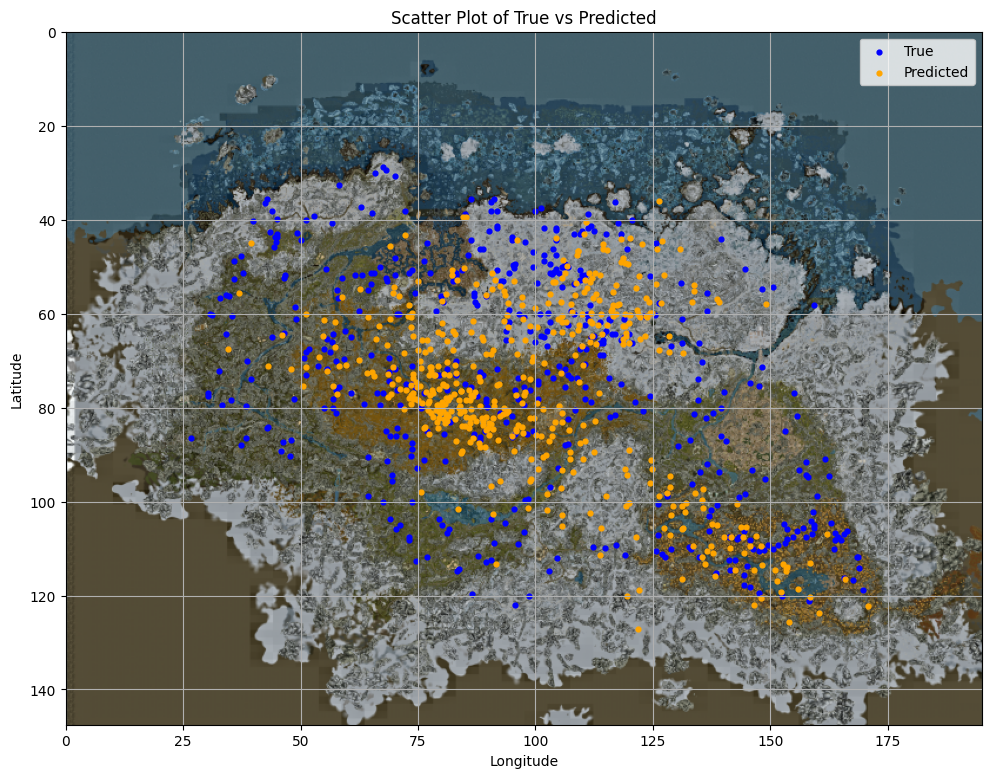

In [21]:
fig_test, ax_test = plt.subplots(figsize=(12, 9))
ax_test.imshow(BACKGROUND_PLOT_IMAGE, extent=[LONGITUDE_MIN, LONGITUDE_MAX, LATITUDE_MAX, LATITUDE_MIN])

plt.scatter(y_true[:, 0], -1 * y_true[:, 1], c="blue", label="True", s=12)
plt.scatter(y_pred[:, 0], -1 * y_pred[:, 1], c="orange", label="Predicted", s=12)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter Plot of True vs Predicted")

plt.legend()
plt.grid(True)
plt.show()